In [2]:
import numpy as np

import pandas as pd

import seaborn as sns
import  matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from lib.mcalc import gcf2ann, spike2bin, spikeCoin
from lib.mviz import visSpk

### Trial-by-trial variability

[ 2.21  2.17 15.45]


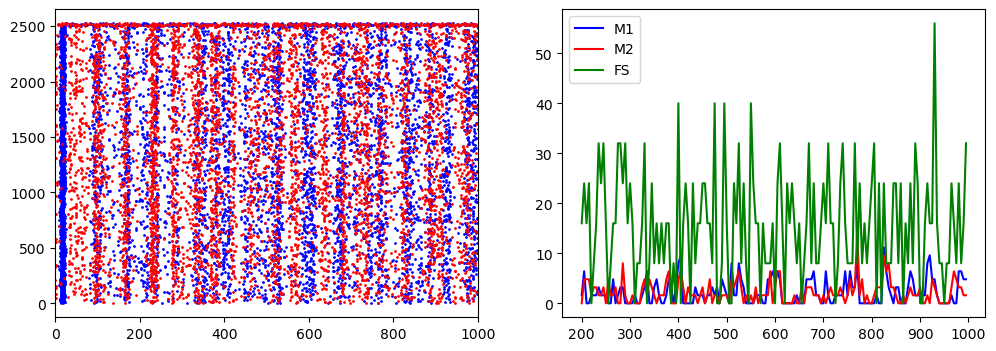

In [2]:
# data setting
Nm = 1250
nMSN = Nm // 10
T, dt = 1000, 0.1

Nf = 25
D = 2.0
W = 0.01

recpath = './data/var-D%.1f'%D
label = '/Nf%d-W%s/'%(Nf, W)
colors = ['blue', 'red', 'green']

# Function to load data and plot
def load_and_plot(ax, recpath, label, colors, T):
    data = np.load(recpath + label + 'spk.npz')
    es, ts = data.f.arr_0, data.f.arr_1
    for e, c in enumerate(colors): 
        ta, tb = e*T, (e+1)*T
        idx = (ts>=ta) & (ts<tb)
        ax.scatter(ts[idx]-ta, es[idx], s=1, c=c)
    ax.set_xlim(0, T)

def plot_population_rates(ax, recpath, label, Nm, nMSN, Nf, T, binsize=5):
    data = np.load(recpath + label + 'spk.npz')
    es, ts = data.f.arr_0, data.f.arr_1

    nNums = [Nm, Nm, Nf]
    labels = ['M1', 'M2', 'FS']
    cs = ['blue', 'red', 'green']

    e=0
    ta, tb = e*T, (e+1)*T
    idx = (ts>=ta) & (ts<tb)

    idBins = np.array([0, Nm-2*nMSN, Nm-nMSN, Nm, Nm+nMSN, Nm+2*nMSN, 2*Nm, 2*Nm+Nf]) + 1
    tmBins = np.arange(200, T+1, binsize)
    rates = np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0] * 1e3 / binsize
    rates = rates[:, np.array([2, 3, -1])]
    rates = rates/np.array([nMSN, nMSN, Nf])

    tms = tmBins[:-1] + e*T
    xs, ys = [tms]*len(nNums), rates.T
    for x, y, c in zip(xs, ys, cs):
        ax.plot(x, y, c=c)
    ax.legend(labels)

    print(rates.mean(axis=0))

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Load data and plot
load_and_plot(axs[0], recpath, label, colors, T)
plot_population_rates(axs[1], recpath, label, Nm, nMSN, Nf, T)

plt.show()

In [6]:
# data setting
Nm = 1250
epoch = 10
T, dt = 2500, 0.1

# range of parameters
Nfs = np.array([0, 25, 30, 50, 90, 150, 250])
Ws = np.array([0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5])
D = 2.0

recpath = './data/var-D%.1f'%D
binsize = 5

# Function to process data and calculate statistics
def process_data(Nf, W):
    label = '/Nf%d-W%s/'%(Nf, W)
    data = np.load(recpath + label + 'spk.npz')
    es, ts = data.f.arr_0, data.f.arr_1
    data.close()

    # processing data
    rates = []
    for e in np.arange(0, epoch):
        ta, tb = e*T+500, (e+1)*T
        idx = (ts>=ta) & (ts<tb) & (es<=2*Nm)

        idBins = np.arange(0, 2*Nm+1, 2*Nm)
        tmBins = np.arange(0, T+1-500, binsize)
        rates.append(np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0])
    rates = np.array(rates)[:,:,0]
    
    # variability
    fanos = rates.var(axis=0)/rates.mean(axis=0)
    fano = np.mean(fanos[~np.isnan(fanos)])

    # correlation
    cors = np.corrcoef(rates)
    corr = (np.sum(cors)-np.trace(cors))/cors.shape[0]/(cors.shape[0]-1)

    return [Nf, W, np.mean(rates*1e3/binsize/2/Nm), fano, corr]

# Process data and save results
frames = [process_data(Nf, W) for Nf in Nfs for W in Ws]
print(frames)
colname = ['Nf', 'Win', 'rout', 'Fano', 'Corr']
stats = pd.DataFrame(np.array(frames), columns=colname)

np.savez('./exp/var/stats-D%.1f.npz'%D, np.array(frames))
stats.to_csv('./exp/var/stats-D%.1f.csv'%D)

/var/folders/32/1rfbx39j19j6ff9b4l5xgn3m0000gn/T/ipykernel_43706/3969769761.py:33: RuntimeWarning: invalid value encountered in divide
  fanos = rates.var(axis=0)/rates.mean(axis=0)


[[0, 0.01, 2.1177200000000003, 0.9593174594271707, 0.6297271769353794], [0, 0.025, 2.15834, 0.9350182804066265, 0.836929465583006], [0, 0.05, 2.1687200000000004, 0.9883879002295971, 0.8619871652899915], [0, 0.075, 2.2088, 1.00440217691119, 0.909239283618208], [0, 0.1, 2.2788600000000003, 1.0285612400637754, 0.9477534960357704], [0, 0.2, 2.32496, 0.9864743272069444, 0.9650138167245704], [0, 0.3, 2.3033999999999994, 0.9548567823132269, 0.9798535193836098], [0, 0.4, 2.49624, 1.0487239758700968, 0.9861962069971438], [0, 0.5, 2.72068, 1.1148174590117421, 0.9857846526749413], [25, 0.01, 2.0794, 8.815564494847074, 0.09411697138037461], [25, 0.025, 2.0995, 8.909909215424285, 0.18463928745815794], [25, 0.05, 2.1236400000000004, 9.335398254838433, 0.30426237429420655], [25, 0.075, 2.16104, 9.211780967353254, 0.46039426663658056], [25, 0.1, 2.18712, 9.579434768747522, 0.5017521254158025], [25, 0.2, 2.32538, 9.163133451609903, 0.7093896573319949], [25, 0.3, 2.38378, 8.678945381005825, 0.7307186135

In [5]:
# plot font size
plt.rcParams.update({'font.size': 16})

# data setting
Nm = 1250
nMSN = Nm // 10
epoch = 10
T, dt = 2500, 0.1

# range of parameters
Nfs = np.array([0, 25, 30, 50, 90, 150, 250])
Ws = np.array([0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5])
D = 2.0

recpath = './data/var-D%.1f'%D
binsize = 5
# grpsize = 25

# load extracted data
stats = pd.read_csv('./exp/var/stats-D%.1f.csv'%D)
fig_corr = np.reshape(stats['Corr'].to_numpy(), newshape=(len(Nfs), len(Ws)));
fig_rate = np.reshape(stats['rout'].to_numpy(), newshape=(len(Nfs), len(Ws)));
fig_fano = np.reshape(stats['Fano'].to_numpy(), newshape=(len(Nfs), len(Ws)));

# Create a 4x2 grid
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 0.2, 1])
# Create subplots
fig = plt.figure(figsize=(9,4))
# Assign each subplot to a position in the grid
ax1 = fig.add_subplot(gs[0, 0])
ax_n = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 2])
ax_b = fig.add_subplot(gs[1, 1])

Nf_s = [250, 25]
W_s = [0.1, 0.1]
# colors = ['green', 'blue', 'red', 'black', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']
colors = ['blue', 'red']
idBins = np.array([0, 2*Nm])
tmBins = np.arange(0, T+1-500, binsize)

axs = [ax1, ax2, ax3, ax4]
for i, NfW in enumerate(zip(Nf_s, W_s)):
    Nf, W = NfW[0], NfW[1]
    label = '/Nf%d-W%s/'%(Nf, W)
    data = np.load(recpath + label + 'spk.npz')
    es, ts = data.f.arr_0, data.f.arr_1

    ax = axs[i]
    ax.set_title(r'$N_{fsi}=%d, W_{in}=%s$'%(Nf, W), fontsize=16)
    for e, c in enumerate(colors): 
        ta, tb = e*T, (e+1)*T
        idx = (ts>=ta) & (ts<tb)
        ax.scatter((ts[idx]-ta)/1000, es[idx], s=1, c=c)
    ax.set_ylim(0, 2*nMSN)
    if i==0:
        ax.set_ylabel('Nrn ID')
    else:
        ax.set_yticks([])
    ax.set_xlim(1, 2)
    ax.set_xticks([])

    ax=axs[i+2]
    for e, c in enumerate(colors):
        ta, tb = e*T+500, (e+1)*T
        idx = (ts>=ta) & (ts<tb) & (es<=idBins[-1])
        rates = np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0] * 1e3 / binsize /idBins[-1]
        ax.plot(tmBins[:-1]/1000, rates, c=c)
    if i==0:
        ax.set_ylabel('Rate (Hz)')
        ax.set_xlabel('Time (s)')
    else:
        ax.set_xlabel('Time (s)')
        ax.set_yticks([])
    ax.set_xlim(1, 2)
    ax.set_ylim(0, 20.0)

Nf = 25
W = -0.01
label = '/Nf%d-W%s/'%(Nf, W)
data = np.load(recpath + label + 'spk.npz')
es, ts = data.f.arr_0, data.f.arr_1

for e, c in enumerate(colors): 
    ta, tb = e*T, (e+1)*T
    idx = (ts>=ta) & (ts<tb)
    ax_n.scatter(ts[idx]-ta, es[idx], s=1, c=c)
ax_n.set_yticks([])
ax_n.set_xticks([])
ax_n.set_xlim(900, 1100)
ax_n.set_ylim(0, 2*nMSN)
ax_n.set_title('spon.', fontsize=10)

for e, c in enumerate(colors):
    ta, tb = e*T+500, (e+1)*T
    idx = (ts>=ta) & (ts<tb) & (es<=idBins[-1])
    rates = np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0] * 1e3 / binsize /idBins[-1]
    ax_b.plot(tmBins[:-1], rates, c=c)
ax_b.set_xticks([])
ax_b.set_yticks([])
ax_b.set_xlim(900, 1100)
ax_b.set_ylim(0, 2*nMSN)
ax_b.set_xlabel('0.2s', labelpad=20)

plt.subplots_adjust(wspace=0.1)
plt.savefig('./plot/var_spike.pdf', transparent=True, bbox_inches='tight', dpi=500)
plt.close()

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, axes = plt.subplots(1, 2, figsize=(8, 6))
idx = np.array([0, 4, 8])
ax = axes[0]
ax.set_title('Rate control', fontsize=16)
im = ax.imshow(fig_rate[np.ix_(np.concatenate([np.arange(1,len(Nfs)), [0]]), np.arange(len(Ws)))])
ax.set_xlabel(r'$W_{in}$')
ax.set_xticks(idx, Ws[idx]);
ax.set_ylabel(r'$N_{fsi}$')
ax.set_yticks(np.arange(len(Nfs)), np.concatenate([Nfs[1:], [Nfs[0]]]));
# Create an inset axes for the colorbar
cax = inset_axes(ax,
                 width="5%",  # width = 5% of parent_bbox width
                 height="100%",  # height : 100%
                 loc='lower left',
                 bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
# Add the colorbar to the figure
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r'$r_{out}(Hz)$')
# label the point 300, 0.3 with labal 'A'
ax.text(3.75, 5.25, 'A', fontsize=16, color='white')
# label the point 50, 0.05 with labal 'B'
ax.text(3.75, 0.25, 'B', fontsize=16, color='black')

ax = axes[1]
# make title font smaller
ax.set_title('Variability control', fontsize=16)
im = ax.imshow(fig_fano[np.ix_(np.concatenate([np.arange(1,len(Nfs)), [0]]), np.arange(len(Ws)))])
ax.set_xlabel(r'$W_{in}$')
ax.set_xticks(idx, Ws[idx]);
ax.set_yticks([])
# Create an inset axes for the colorbar
cax = inset_axes(ax,
                 width="5%",  # width = 5% of parent_bbox width
                 height="100%",  # height : 100%
                 loc='lower left',
                 bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
# Add the colorbar to the figure
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Fano factor')
# label the point 300, 0.3 with labal 'A'
ax.text(3.75, 5.25, 'A', fontsize=16, color='white')
# label the point 50, 0.05 with labal 'B'
ax.text(3.75, 0.25, 'B', fontsize=16, color='black')

plt.subplots_adjust(wspace=0.6)
plt.savefig('./plot/var_tran.pdf', transparent=True, bbox_inches='tight', dpi=500)
plt.close()

plt.figure(figsize=(8, 2))
Nf = 25
W = -0.01
label = '/Nf%d-W%s/'%(Nf, W)
data = np.load(recpath + label + 'spk.npz')
es, ts = data.f.arr_0, data.f.arr_1

plt.title(r'$N_{fsi}=%d$'%(Nf), fontsize=16)
for e, c in enumerate(colors): 
    ta, tb = e*T, (e+1)*T
    idx = (ts>=ta) & (ts<tb)
    plt.scatter(ts[idx]-ta, es[idx], s=1, c=c)
plt.xlim(1000, 2000)
plt.ylim(Nm-2*nMSN, Nm+2*nMSN)
plt.ylabel('Nrn ID')
plt.xlabel('Time (s)')

plt.savefig('./plot/var_spon.pdf', transparent=True, bbox_inches='tight', dpi=500)
plt.close()